In [1]:
import os
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import random

class UncertaintyAugmentation(object):
    """Add uncertainty through various augmentations"""
    def __init__(self, noise_level=0.1, occlusion_prob=0.2, blur_prob=0.2):
        self.noise_level = noise_level
        self.occlusion_prob = occlusion_prob
        self.blur_prob = blur_prob

    def __call__(self, sample):
        """Apply transformations to either a dictionary with 'image' key or directly to a PIL/tensor image"""
        # Check if the sample is a dictionary with 'image' key or directly an image
        if isinstance(sample, dict) and 'image' in sample:
            image = sample['image']
            is_dict = True
        else:
            image = sample
            is_dict = False

        # Convert PIL Image to tensor if needed
        if isinstance(image, Image.Image):
            image = transforms.ToTensor()(image)

        # Add Gaussian noise
        if random.random() < 0.5:
            noise = torch.randn_like(image) * self.noise_level
            image = image + noise
            image = torch.clamp(image, 0, 1)

        # Add random occlusion
        if random.random() < self.occlusion_prob:
            h, w = image.shape[-2:]

            # Create random rectangle for occlusion
            occlusion_width = random.randint(w // 10, w // 3)
            occlusion_height = random.randint(h // 10, h // 3)
            x = random.randint(0, w - occlusion_width)
            y = random.randint(0, h - occlusion_height)

            # Apply occlusion
            image[:, y:y+occlusion_height, x:x+occlusion_width] = 0

        # Add blur effect
        if random.random() < self.blur_prob and isinstance(image, torch.Tensor):
            # Convert to PIL for Gaussian blur
            to_pil = transforms.ToPILImage()
            to_tensor = transforms.ToTensor()

            # Convert tensor to PIL
            pil_image = to_pil(image)

            # Apply Gaussian blur
            blurred = transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))(pil_image)

            # Convert back to tensor
            image = to_tensor(blurred)

        # Return in the same format as received
        if is_dict:
            sample['image'] = image
            return sample
        else:
            return image


class VehicularPerceptionDataset(data.Dataset):
    def __init__(self, root_dir, transform=None, is_training=True, num_vehicles=5, adversarial_prob=0.0):
        """
        Args:
            root_dir (string): Directory with images
            transform (callable, optional): Optional transform to be applied on samples
            is_training (bool): Whether this is for training or validation
            num_vehicles (int): Number of vehicles in collaborative perception
            adversarial_prob (float): Probability of generating adversarial samples during training
        """
        self.root_dir = root_dir
        self.is_training = is_training
        self.num_vehicles = num_vehicles
        self.adversarial_prob = adversarial_prob

        # Define default transforms if none provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transform

        self.samples = self._load_samples()

    def _load_samples(self):
        """Load sample paths from Google Drive image directory"""
        samples = []

        # Verify Google Drive is mounted
        if not os.path.exists('/content/drive'):
            # Try to mount Google Drive if not already mounted
            try:
                from google.colab import drive
                drive.mount('/content/drive')
                print("Google Drive mounted successfully")
            except:
                raise RuntimeError("Failed to mount Google Drive. Please run 'from google.colab import drive; drive.mount('/content/drive')' first")

        # Check if specific directory exists in Google Drive
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(f"Dataset directory {self.root_dir} not found in Google Drive")

        # Find all image files
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

        try:
            image_files = [f for f in os.listdir(self.root_dir)
                          if os.path.isfile(os.path.join(self.root_dir, f)) and
                          any(f.lower().endswith(ext) for ext in valid_extensions)]

            print(f"Found {len(image_files)} images in {self.root_dir}")

            # Create sample entries
            for img_name in image_files:
                img_path = os.path.join(self.root_dir, img_name)

                # Create a simple sample entry without annotations
                sample = {
                    'image_path': img_path,
                    'vehicle_id': 0,  # Main ego vehicle
                    'frame_id': img_name.split('.')[0]  # Use filename as frame ID
                }

                samples.append(sample)

        except Exception as e:
            print(f"Error accessing files in Google Drive: {e}")
            raise

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load image data
        sample_info = self.samples[idx]
        image_path = sample_info['image_path']

        try:
            # Load the image using PIL
            image = Image.open(image_path).convert("RGB")

            # Apply transformations directly to the PIL image
            if self.transform:
                image_tensor = self.transform(image)  # This should now work with either transform type
            else:
                # Default transformation if none provided
                image_tensor = transforms.ToTensor()(image)

            # Create the base sample
            sample = {
                'image': image_tensor,
                'vehicle_id': sample_info['vehicle_id'],
                'frame_id': sample_info['frame_id']
            }

            # For collaborative perception, simulate data from multiple vehicles
            if self.num_vehicles > 1:
                vehicle_images = [image_tensor]  # Start with the ego vehicle's image

                # Generate simulated views from other vehicles
                for v in range(1, self.num_vehicles):
                    # Apply random transformation to simulate different viewpoint
                    vehicle_image = self._simulate_vehicle_view(image_tensor, v)

                    # Add adversarial perturbation with specified probability during training
                    if self.is_training and random.random() < self.adversarial_prob:
                        vehicle_image = self._apply_adversarial_perturbation(vehicle_image)
                        sample[f'vehicle_{v}_is_adversarial'] = torch.tensor([1.0])
                    else:
                        sample[f'vehicle_{v}_is_adversarial'] = torch.tensor([0.0])

                    vehicle_images.append(vehicle_image)

                sample['vehicle_images'] = vehicle_images

            return sample

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a default sample in case of error
            return self.__getitem__((idx + 1) % len(self.samples))

    def _simulate_vehicle_view(self, image_tensor, vehicle_id):
      """Simulate different viewpoints from other vehicles with padding"""
      # Apply random transformations to simulate different viewpoints

      # Create a random affine transformation
      angle = random.uniform(-15, 15)
      translate = (random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1))
      scale = random.uniform(0.9, 1.1)

      # Convert tensor back to PIL for transformation
      to_pil = transforms.ToPILImage()
      to_tensor = transforms.ToTensor()
      normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

      # If the tensor is normalized, denormalize it first
      if image_tensor.min() < 0:
          pil_image = to_pil(image_tensor * 0.5 + 0.5)  # Denormalize
      else:
          pil_image = to_pil(image_tensor)

      # Create a padded image with gray background
      width, height = pil_image.size
      padded_image = Image.new('RGB', (int(width * 1.2), int(height * 1.2)), (128, 128, 128))
      padded_image.paste(pil_image, (int(width * 0.1), int(height * 0.1)))

      # Apply the transformation without fillcolor
      transformed = transforms.functional.affine(
          padded_image, angle, translate, scale, 0
      )

      # Crop back to original size
      transformed = transforms.CenterCrop((height, width))(transformed)

      # Convert back to tensor and normalize if the original was normalized
      transformed_tensor = to_tensor(transformed)
      if image_tensor.min() < 0:
          transformed_tensor = normalize(transformed_tensor)

      return transformed_tensor

    def _apply_adversarial_perturbation(self, image_tensor, magnitude=0.1):
        """Apply adversarial perturbation to the image"""
        # Simple implementation: add random noise
        noise = torch.randn_like(image_tensor) * magnitude

        # Check if tensor is normalized
        if image_tensor.min() < 0:
            # For normalized images (-1 to 1 range)
            perturbed_image = image_tensor + noise
            perturbed_image = torch.clamp(perturbed_image, -1, 1)
        else:
            # For standard images (0 to 1 range)
            perturbed_image = image_tensor + noise
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

        return perturbed_image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class FeatureCompressionVAE(nn.Module):
    def __init__(self, input_channels=3, latent_dim=64):
        super(FeatureCompressionVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        # Calculate flattened feature size
        self.feature_size = 256 * 8 * 8

        # Mean and variance layers
        self.fc_mu = nn.Linear(self.feature_size, latent_dim)
        self.fc_var = nn.Linear(self.feature_size, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, self.feature_size)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.Tanh()  # Output normalized between -1 and 1
        )

    def encode(self, x):
        # Encode the input
        x = self.encoder(x)
        x = x.view(-1, self.feature_size)

        # Get latent distribution parameters
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return mu, log_var

    def reparameterize(self, mu, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        # Decode from latent space
        x = self.decoder_input(z)
        x = x.view(-1, 256, 8, 8)
        x = self.decoder(x)
        return x

    def forward(self, x):
        # Encode
        mu, log_var = self.encode(x)

        # Get latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # Feature selection - keep top-k features based on importance
        importance = torch.abs(z)
        k = int(0.7 * z.size(1))  # Keep 70% of features (adjust as needed)
        _, indices = torch.topk(importance, k=k, dim=1)

        # Create sparse latent representation - set non-top-k values to zero
        batch_size = z.size(0)
        z_sparse = torch.zeros_like(z)

        for i in range(batch_size):
            z_sparse[i, indices[i]] = z[i, indices[i]]

        # Decode
        reconstructed = self.decode(z_sparse)

        return reconstructed, mu, log_var, z_sparse

    def loss_function(self, recon_x, x, mu, log_var, kld_weight=0.005):
        """
        Calculate VAE loss with reconstruction and KL divergence terms
        """
        # Reconstruction loss (using MSE for image data)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')

        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss
        loss = recon_loss + kld_weight * kld_loss

        return loss, recon_loss, kld_loss

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DiffusionModel(nn.Module):
    def __init__(self, feature_dim=64, timesteps=100):
        super(DiffusionModel, self).__init__()
        self.feature_dim = feature_dim
        self.timesteps = timesteps

        # Define noise predictor network
        self.noise_predictor = nn.Sequential(
            nn.Linear(feature_dim + 1, 128),  # +1 for time embedding
            nn.SiLU(),
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, feature_dim)
        )

        # Define beta schedule (noise level at each timestep)
        self.beta = self._cosine_beta_schedule()
        self.alpha = 1. - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

    def _cosine_beta_schedule(self):
        """
        Cosine beta schedule for diffusion process - smoother noise addition
        """
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.timesteps) + 0.008) / 1.008 * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def add_noise(self, x, t):
        """
        Add noise to features based on diffusion process at timestep t
        """
        # Get noise scaling for timestep t
        # Move alpha_cumprod to the same device as t
        a_t = self.alpha_cumprod.to(t.device)[t]

        # Expand dimensions for proper broadcasting
        a_t = a_t.reshape(-1, 1)

        # Generate random noise
        noise = torch.randn_like(x)

        # Apply noise based on diffusion equation: x_t = sqrt(a_t) * x_0 + sqrt(1-a_t) * ε
        noisy_x = torch.sqrt(a_t) * x + torch.sqrt(1 - a_t) * noise

        return noisy_x, noise

    def forward(self, x, t):
        """
        Forward pass to predict noise at timestep t
        """
        # Time embedding (normalized)
        t_emb = t.float() / self.timesteps
        t_emb = t_emb.reshape(-1, 1)

        # Concat input with time embedding
        x_t = torch.cat([x, t_emb], dim=1)

        # Predict noise
        predicted_noise = self.noise_predictor(x_t)

        return predicted_noise

    def sample(self, shape, device, steps=None):
        """
        Generate new features from noise using reverse diffusion
        """
        if steps is None:
            steps = self.timesteps

        # Start from pure noise
        x = torch.randn(shape).to(device)

        # Reverse diffusion process (denoise step by step)
        for t in range(steps - 1, -1, -1):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)

            # No gradient needed for sampling
            with torch.no_grad():
                # Get current time step beta
                beta_t = self.beta[t]

                # Predict noise
                predicted_noise = self.forward(x, t_tensor)

                # No noise for final step
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0

                # Update x based on reverse diffusion equation
                x = (1 / torch.sqrt(1 - beta_t)) * (x - (beta_t / torch.sqrt(1 - self.alpha_cumprod[t])) * predicted_noise) + torch.sqrt(beta_t) * noise

        return x

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Import the models and dataset
# Make sure these classes are defined in your project
# from models.feature_compression import FeatureCompressionVAE
# from models.diffusion import DiffusionModel
# from data.dataset import VehicularPerceptionDataset, UncertaintyAugmentation

def train_adversarial_defense_system():
    """
    Complete training function for the adversarial defense system
    """
    # Configuration
    class Config:
        # Paths
        data_dir = '/content/drive/MyDrive/CVProject/'
        output_dir = '/content/drive/MyDrive/CVProject/output/'

        # Model parameters
        input_channels = 3
        image_size = 128
        latent_dim = 64
        num_vehicles = 5
        diffusion_timesteps = 100

        # Training parameters
        batch_size = 8
        num_workers = 2
        num_epochs = 50
        lr = 1e-4
        beta1 = 0.9
        beta2 = 0.999

        # Loss parameters
        kld_weight = 0.005  # Weight for KL divergence in VAE loss

        # Adversarial parameters
        adversarial_prob = 0.3  # Probability of generating adversarial samples
        adversarial_magnitude = 0.2  # Magnitude of adversarial perturbation

        # Save parameters
        save_interval = 5  # Save checkpoint every N epochs

        # Device settings
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Set random seed for reproducibility
        seed = 42

    config = Config()

    # Create output directory if it doesn't exist
    os.makedirs(config.output_dir, exist_ok=True)
    os.makedirs(os.path.join(config.output_dir, 'logs'), exist_ok=True)

    # Set random seeds for reproducibility
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config.seed)

    print(f"Using device: {config.device}")

    # Initialize tensorboard for tracking
    writer = SummaryWriter(log_dir=os.path.join(config.output_dir, 'logs'))

    # Create dataset and dataloader
    # First define the transformations
    transform = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        UncertaintyAugmentation(noise_level=0.1, occlusion_prob=0.2, blur_prob=0.2)
    ])

    # Create dataset
    dataset = VehicularPerceptionDataset(
        root_dir=config.data_dir,
        transform=transform,
        is_training=True,
        num_vehicles=config.num_vehicles,
        adversarial_prob=config.adversarial_prob
    )

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True
    )

    print(f"Dataset created with {len(dataset)} images, {config.num_vehicles} simulated vehicles")

    # Initialize models
    # 1. Variational Autoencoder for feature compression
    vae = FeatureCompressionVAE(
        input_channels=config.input_channels,
        latent_dim=config.latent_dim
    ).to(config.device)

    # 2. Diffusion model for uncertainty modeling
    diffusion = DiffusionModel(
        feature_dim=config.latent_dim,
        timesteps=config.diffusion_timesteps
    ).to(config.device)

    # Initialize optimizers
    vae_optimizer = optim.Adam(
        vae.parameters(),
        lr=config.lr,
        betas=(config.beta1, config.beta2)
    )

    diffusion_optimizer = optim.Adam(
        diffusion.parameters(),
        lr=config.lr,
        betas=(config.beta1, config.beta2)
    )

    # Create learning rate schedulers (optional but helpful)
    vae_scheduler = optim.lr_scheduler.StepLR(vae_optimizer, step_size=10, gamma=0.5)
    diffusion_scheduler = optim.lr_scheduler.StepLR(diffusion_optimizer, step_size=10, gamma=0.5)

    # Training loop
    print("Starting training...")
    global_step = 0
    best_loss = float('inf')

    for epoch in range(config.num_epochs):
        vae.train()
        diffusion.train()

        # Track losses for this epoch
        epoch_vae_loss = 0.0
        epoch_diffusion_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_kld_loss = 0.0

        start_time = time.time()

        # Process each batch
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}")

        for batch_idx, batch in enumerate(progress_bar):
            # Process vehicle images
            if 'vehicle_images' in batch:
                # Get all vehicle images
                all_vehicle_images = batch['vehicle_images']
                batch_size = all_vehicle_images[0].shape[0]

                # Move to device (GPU if available)
                vehicle_images = [img.to(config.device) for img in all_vehicle_images]

                # 1. Train VAE with ego vehicle images (clean reference)
                vae_optimizer.zero_grad()

                # Forward pass through VAE
                ego_images = vehicle_images[0]  # Main vehicle (non-adversarial)
                recon_images, mu, log_var, z_sparse = vae(ego_images)

                # Calculate VAE loss components
                vae_loss, recon_loss, kld_loss = vae.loss_function(
                    recon_images, ego_images, mu, log_var, kld_weight=config.kld_weight
                )

                # Backward pass and optimize VAE
                vae_loss.backward()
                vae_optimizer.step()

                # 2. Train Diffusion model with latent vectors
                diffusion_optimizer.zero_grad()

                # Sample random timestep
                t = torch.randint(0, config.diffusion_timesteps, (batch_size,), device=config.device)

                # Add noise to latent vector according to timestep
                noisy_z, noise = diffusion.add_noise(z_sparse.detach(), t)

                # Predict noise with diffusion model
                predicted_noise = diffusion(noisy_z, t)

                # Calculate diffusion loss (noise prediction MSE)
                diffusion_loss = torch.nn.functional.mse_loss(predicted_noise, noise)

                # Backward pass and optimize diffusion model
                diffusion_loss.backward()
                diffusion_optimizer.step()

                # Track losses
                epoch_vae_loss += vae_loss.item()
                epoch_recon_loss += recon_loss.item()
                epoch_kld_loss += kld_loss.item()
                epoch_diffusion_loss += diffusion_loss.item()

                # Update progress bar
                progress_bar.set_postfix({
                    'VAE Loss': f"{vae_loss.item():.4f}",
                    'Diff Loss': f"{diffusion_loss.item():.4f}"
                })

                # Log metrics to tensorboard
                writer.add_scalar('Loss/VAE_Total', vae_loss.item(), global_step)
                writer.add_scalar('Loss/VAE_Reconstruction', recon_loss.item(), global_step)
                writer.add_scalar('Loss/VAE_KLD', kld_loss.item(), global_step)
                writer.add_scalar('Loss/Diffusion', diffusion_loss.item(), global_step)

                # Visualize reconstructions periodically
                if global_step % 100 == 0:
                    with torch.no_grad():
                        # Get original and reconstructed images
                        orig_imgs = ego_images[:4].detach().cpu()
                        recon_imgs = recon_images[:4].detach().cpu()

                        # Create grid with original and reconstructed
                        comparison = torch.cat([orig_imgs, recon_imgs], dim=0)

                        # Convert from [-1,1] to [0,1] for visualization
                        comparison = (comparison + 1) / 2

                        # Add to tensorboard
                        writer.add_images('Images/Reconstruction', comparison, global_step)

                        # If we've trained enough, generate samples from the diffusion model
                        if epoch > 5:  # Wait until diffusion model has learned something
                            try:
                                # Sample latent vectors from the diffusion model
                                sampled_z = diffusion.sample(
                                    shape=(4, config.latent_dim),
                                    device=config.device,
                                    steps=50  # Use fewer steps for visualization
                                )

                                # Decode the sampled latent vectors
                                sampled_images = vae.decode(sampled_z)

                                # Convert from [-1,1] to [0,1] for visualization
                                sampled_images = (sampled_images + 1) / 2

                                # Add to tensorboard
                                writer.add_images('Images/Generated', sampled_images, global_step)
                            except Exception as e:
                                print(f"Error generating samples: {e}")

                global_step += 1
            else:
                print("Warning: Batch does not contain 'vehicle_images' key")

        # Update learning rate schedulers
        vae_scheduler.step()
        diffusion_scheduler.step()

        # Calculate average losses for the epoch
        avg_vae_loss = epoch_vae_loss / len(dataloader)
        avg_recon_loss = epoch_recon_loss / len(dataloader)
        avg_kld_loss = epoch_kld_loss / len(dataloader)
        avg_diffusion_loss = epoch_diffusion_loss / len(dataloader)

        epoch_time = time.time() - start_time

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{config.num_epochs} completed in {epoch_time:.2f}s")
        print(f"VAE Loss: {avg_vae_loss:.4f} (Recon: {avg_recon_loss:.4f}, KLD: {avg_kld_loss:.4f})")
        print(f"Diffusion Loss: {avg_diffusion_loss:.4f}")

        # Save model checkpoint if it's the best so far
        if avg_vae_loss + avg_diffusion_loss < best_loss:
            best_loss = avg_vae_loss + avg_diffusion_loss

            # Save best model
            torch.save({
                'epoch': epoch,
                'vae_state_dict': vae.state_dict(),
                'diffusion_state_dict': diffusion.state_dict(),
                'vae_optimizer': vae_optimizer.state_dict(),
                'diffusion_optimizer': diffusion_optimizer.state_dict(),
                'loss': best_loss,
            }, os.path.join(config.output_dir, 'best_model.pt'))

            print(f"✅ Saved best model checkpoint with loss: {best_loss:.4f}")

        # Save regular checkpoint at intervals
        if (epoch + 1) % config.save_interval == 0:
            torch.save({
                'epoch': epoch,
                'vae_state_dict': vae.state_dict(),
                'diffusion_state_dict': diffusion.state_dict(),
                'vae_optimizer': vae_optimizer.state_dict(),
                'diffusion_optimizer': diffusion_optimizer.state_dict(),
            }, os.path.join(config.output_dir, f'checkpoint_epoch_{epoch+1}.pt'))

            print(f"📁 Saved checkpoint at epoch {epoch+1}")

    # Save final model
    torch.save({
        'vae_state_dict': vae.state_dict(),
        'diffusion_state_dict': diffusion.state_dict(),
    }, os.path.join(config.output_dir, 'final_model.pt'))

    print(f"🎉 Training completed! Final model saved to {config.output_dir}")
    writer.close()

    return vae, diffusion


if __name__ == "__main__":
    # Make sure Google Drive is mounted
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    except:
        print("Not running in Colab or Drive already mounted")

    # Import necessary modules
    import torch
    from torchvision import transforms

    # Start training
    vae, diffusion = train_adversarial_defense_system()

    print("Training complete!")

Mounted at /content/drive
Google Drive mounted successfully
Using device: cuda
Found 74 images in /content/drive/MyDrive/CVProject/
Dataset created with 74 images, 5 simulated vehicles
Starting training...


Epoch 1/50:  67%|██████▋   | 6/9 [00:22<00:09,  3.11s/it, VAE Loss=129413.2812, Diff Loss=1.0225]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 1/50: 100%|██████████| 9/9 [00:34<00:00,  3.79s/it, VAE Loss=81356.1562, Diff Loss=1.0048]



Epoch 1/50 completed in 34.15s
VAE Loss: 134616.2083 (Recon: 134610.2127, KLD: 1199.1952)
Diffusion Loss: 1.0119
✅ Saved best model checkpoint with loss: 134617.2202


Epoch 2/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 2/50: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s, VAE Loss=87375.1641, Diff Loss=1.4291]



Epoch 2/50 completed in 2.39s
VAE Loss: 124484.3351 (Recon: 89815.0477, KLD: 6933858.1437)
Diffusion Loss: 2.5176
✅ Saved best model checkpoint with loss: 124486.8526


Epoch 3/50:  33%|███▎      | 3/9 [00:01<00:01,  3.56it/s, VAE Loss=86227.5938, Diff Loss=1.0066]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 3/50: 100%|██████████| 9/9 [00:01<00:00,  4.79it/s, VAE Loss=76155.3125, Diff Loss=1.6579]



Epoch 3/50 completed in 1.88s
VAE Loss: 80954.0495 (Recon: 76878.1137, KLD: 815187.3107)
Diffusion Loss: 1.6939
✅ Saved best model checkpoint with loss: 80955.7433


Epoch 4/50:  56%|█████▌    | 5/9 [00:01<00:00,  4.01it/s, VAE Loss=102391.7656, Diff Loss=1.0406]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 4/50: 100%|██████████| 9/9 [00:01<00:00,  4.51it/s, VAE Loss=54314.1523, Diff Loss=0.8769]



Epoch 4/50 completed in 2.00s
VAE Loss: 74295.6541 (Recon: 72647.6458, KLD: 329601.3977)
Diffusion Loss: 1.2519
✅ Saved best model checkpoint with loss: 74296.9060


Epoch 5/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 5/50: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s, VAE Loss=65599.2734, Diff Loss=0.9052]



Epoch 5/50 completed in 3.11s
VAE Loss: 72123.1042 (Recon: 71971.3902, KLD: 30342.8727)
Diffusion Loss: 0.9610
✅ Saved best model checkpoint with loss: 72124.0652
📁 Saved checkpoint at epoch 5


Epoch 6/50:  33%|███▎      | 3/9 [00:00<00:01,  4.44it/s, VAE Loss=63397.5430, Diff Loss=0.9913]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 6/50: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s, VAE Loss=59192.3047, Diff Loss=1.1357]



Epoch 6/50 completed in 1.89s
VAE Loss: 67050.6905 (Recon: 67005.1315, KLD: 9111.8090)
Diffusion Loss: 1.0384
✅ Saved best model checkpoint with loss: 67051.7289


Epoch 7/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 7/50: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s, VAE Loss=64807.4062, Diff Loss=1.0410]



Epoch 7/50 completed in 1.75s
VAE Loss: 60750.4826 (Recon: 60730.8941, KLD: 3917.7077)
Diffusion Loss: 1.0053
✅ Saved best model checkpoint with loss: 60751.4879


Epoch 8/50: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s, VAE Loss=50694.7383, Diff Loss=0.9522]



Epoch 8/50 completed in 2.37s
VAE Loss: 57096.1749 (Recon: 57077.3594, KLD: 3763.2348)
Diffusion Loss: 0.9565
✅ Saved best model checkpoint with loss: 57097.1314


Epoch 9/50:  56%|█████▌    | 5/9 [00:01<00:01,  2.97it/s, VAE Loss=51232.7070, Diff Loss=0.9478]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated

Epoch 9/50:  56%|█████▌    | 5/9 [00:01<00:01,  2.97it/s, VAE Loss=44590.8672, Diff Loss=0.9954]

Epoch 9/50: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, VAE Loss=37473.5898, Diff Loss=1.1154]



Epoch 9/50 completed in 2.55s
VAE Loss: 47116.6267 (Recon: 47090.2530, KLD: 5274.6600)
Diffusion Loss: 1.0132
✅ Saved best model checkpoint with loss: 47117.6400


Epoch 10/50:  56%|█████▌    | 5/9 [00:01<00:01,  3.00it/s, VAE Loss=48951.0625, Diff Loss=0.9680]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 10/50: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s, VAE Loss=54432.8047, Diff Loss=1.0368]



Epoch 10/50 completed in 2.38s
VAE Loss: 49220.4371 (Recon: 49205.1853, KLD: 3050.2463)
Diffusion Loss: 1.0268
📁 Saved checkpoint at epoch 10


Epoch 11/50:  67%|██████▋   | 6/9 [00:01<00:00,  4.90it/s, VAE Loss=55151.3281, Diff Loss=0.8834]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 11/50: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s, VAE Loss=47757.9023, Diff Loss=1.0196]



Epoch 11/50 completed in 2.04s
VAE Loss: 52242.5556 (Recon: 52193.1823, KLD: 9874.6398)
Diffusion Loss: 1.0115


Epoch 12/50:  56%|█████▌    | 5/9 [00:01<00:00,  4.25it/s, VAE Loss=54714.7422, Diff Loss=0.9970]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 12/50: 100%|██████████| 9/9 [00:02<00:00,  4.34it/s, VAE Loss=39795.5742, Diff Loss=1.0071]



Epoch 12/50 completed in 2.08s
VAE Loss: 45674.3342 (Recon: 45649.5009, KLD: 4966.6774)
Diffusion Loss: 0.9977
✅ Saved best model checkpoint with loss: 45675.3319


Epoch 13/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 13/50: 100%|██████████| 9/9 [00:01<00:00,  5.20it/s, VAE Loss=38010.0664, Diff Loss=0.9753]



Epoch 13/50 completed in 1.73s
VAE Loss: 42380.7947 (Recon: 42352.1576, KLD: 5727.5265)
Diffusion Loss: 0.9950
✅ Saved best model checkpoint with loss: 42381.7898


Epoch 14/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 14/50: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s, VAE Loss=38925.6133, Diff Loss=0.9121]



Epoch 14/50 completed in 1.90s
VAE Loss: 46674.3581 (Recon: 46656.5990, KLD: 3551.7958)
Diffusion Loss: 0.9759


Epoch 15/50:  33%|███▎      | 3/9 [00:01<00:02,  2.61it/s, VAE Loss=44102.8008, Diff Loss=1.0705]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 15/50: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s, VAE Loss=41823.2578, Diff Loss=1.0156]



Epoch 15/50 completed in 2.95s
VAE Loss: 42667.1163 (Recon: 42646.8867, KLD: 4045.9120)
Diffusion Loss: 1.0186
📁 Saved checkpoint at epoch 15


Epoch 16/50:  33%|███▎      | 3/9 [00:01<00:02,  2.25it/s, VAE Loss=37855.6367, Diff Loss=0.9564]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 16/50: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, VAE Loss=43036.7031, Diff Loss=1.0044]



Epoch 16/50 completed in 3.03s
VAE Loss: 41049.7921 (Recon: 41029.3424, KLD: 4089.9898)
Diffusion Loss: 1.0432
✅ Saved best model checkpoint with loss: 41050.8353


Epoch 17/50:  33%|███▎      | 3/9 [00:01<00:01,  3.14it/s, VAE Loss=43734.8086, Diff Loss=0.9467]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 17/50: 100%|██████████| 9/9 [00:02<00:00,  4.31it/s, VAE Loss=42028.2969, Diff Loss=1.0432]



Epoch 17/50 completed in 2.09s
VAE Loss: 45254.2361 (Recon: 45236.2964, KLD: 3587.8851)
Diffusion Loss: 1.0176


Epoch 18/50:  11%|█         | 1/9 [00:00<00:03,  2.18it/s, VAE Loss=38763.3906, Diff Loss=1.0335]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 18/50: 100%|██████████| 9/9 [00:01<00:00,  5.20it/s, VAE Loss=39511.1875, Diff Loss=1.0922]



Epoch 18/50 completed in 1.74s
VAE Loss: 38385.4833 (Recon: 38371.2135, KLD: 2853.9362)
Diffusion Loss: 1.0191
✅ Saved best model checkpoint with loss: 38386.5024


Epoch 19/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 19/50: 100%|██████████| 9/9 [00:01<00:00,  4.72it/s, VAE Loss=34211.2578, Diff Loss=1.0234]



Epoch 19/50 completed in 1.91s
VAE Loss: 43339.6267 (Recon: 43324.2856, KLD: 3068.1792)
Diffusion Loss: 1.0171


Epoch 20/50:  11%|█         | 1/9 [00:00<00:03,  2.12it/s, VAE Loss=33090.9961, Diff Loss=0.9460]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 20/50: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s, VAE Loss=26580.4727, Diff Loss=0.9927]



Epoch 20/50 completed in 1.90s
VAE Loss: 33979.5143 (Recon: 33963.8880, KLD: 3125.2786)
Diffusion Loss: 0.9762
✅ Saved best model checkpoint with loss: 33980.4906
📁 Saved checkpoint at epoch 20


Epoch 21/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 21/50: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s, VAE Loss=40031.4922, Diff Loss=1.0373]



Epoch 21/50 completed in 1.99s
VAE Loss: 36420.5074 (Recon: 36406.0315, KLD: 2895.3071)
Diffusion Loss: 0.9815


Epoch 22/50:  11%|█         | 1/9 [00:00<00:03,  2.00it/s, VAE Loss=36463.5430, Diff Loss=0.9445]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 22/50: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s, VAE Loss=37947.6680, Diff Loss=1.0478]



Epoch 22/50 completed in 1.91s
VAE Loss: 36704.2014 (Recon: 36690.2604, KLD: 2788.1391)
Diffusion Loss: 0.9818


Epoch 23/50:  78%|███████▊  | 7/9 [00:01<00:00,  5.01it/s, VAE Loss=33588.3320, Diff Loss=0.9873]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 23/50: 100%|██████████| 9/9 [00:01<00:00,  4.58it/s, VAE Loss=43528.7148, Diff Loss=0.9229]



Epoch 23/50 completed in 1.97s
VAE Loss: 39290.0519 (Recon: 39276.6298, KLD: 2684.4361)
Diffusion Loss: 1.0010


Epoch 24/50:  11%|█         | 1/9 [00:00<00:04,  1.92it/s, VAE Loss=32520.1816, Diff Loss=1.0626]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 24/50: 100%|██████████| 9/9 [00:01<00:00,  4.82it/s, VAE Loss=31243.7383, Diff Loss=0.9910]



Epoch 24/50 completed in 1.87s
VAE Loss: 33664.2687 (Recon: 33649.8989, KLD: 2873.9100)
Diffusion Loss: 1.0236
✅ Saved best model checkpoint with loss: 33665.2923


Epoch 25/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 25/50: 100%|██████████| 9/9 [00:01<00:00,  4.80it/s, VAE Loss=27654.9902, Diff Loss=1.0553]



Epoch 25/50 completed in 1.88s
VAE Loss: 33533.3494 (Recon: 33519.9967, KLD: 2670.5895)
Diffusion Loss: 1.0214
✅ Saved best model checkpoint with loss: 33534.3708
📁 Saved checkpoint at epoch 25


Epoch 26/50:  33%|███▎      | 3/9 [00:01<00:01,  3.18it/s, VAE Loss=23521.9863, Diff Loss=1.0863]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 26/50: 100%|██████████| 9/9 [00:01<00:00,  4.68it/s, VAE Loss=35561.3828, Diff Loss=0.9466]



Epoch 26/50 completed in 1.92s
VAE Loss: 31766.7216 (Recon: 31753.7754, KLD: 2589.3197)
Diffusion Loss: 0.9872
✅ Saved best model checkpoint with loss: 31767.7088


Epoch 27/50:  78%|███████▊  | 7/9 [00:01<00:00,  5.19it/s, VAE Loss=30020.7949, Diff Loss=1.0516]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 27/50: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s, VAE Loss=33451.0312, Diff Loss=0.9785]



Epoch 27/50 completed in 1.79s
VAE Loss: 32963.8190 (Recon: 32951.1701, KLD: 2529.7776)
Diffusion Loss: 0.9786


Epoch 28/50:  11%|█         | 1/9 [00:00<00:03,  2.06it/s, VAE Loss=22627.8164, Diff Loss=0.9730]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 28/50: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s, VAE Loss=28172.2246, Diff Loss=1.0205]



Epoch 28/50 completed in 1.75s
VAE Loss: 30627.3438 (Recon: 30614.6398, KLD: 2540.7520)
Diffusion Loss: 0.9985
✅ Saved best model checkpoint with loss: 30628.3423


Epoch 29/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 29/50: 100%|██████████| 9/9 [00:02<00:00,  4.31it/s, VAE Loss=21077.4668, Diff Loss=1.1388]



Epoch 29/50 completed in 2.09s
VAE Loss: 32241.5022 (Recon: 32229.2166, KLD: 2457.1306)
Diffusion Loss: 0.9687


Epoch 30/50:  78%|███████▊  | 7/9 [00:02<00:00,  3.02it/s, VAE Loss=28255.4316, Diff Loss=1.1634]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 30/50: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s, VAE Loss=27900.3457, Diff Loss=1.0768]



Epoch 30/50 completed in 3.23s
VAE Loss: 31449.4861 (Recon: 31437.6398, KLD: 2369.2810)
Diffusion Loss: 1.0447
📁 Saved checkpoint at epoch 30


Epoch 31/50:  33%|███▎      | 3/9 [00:00<00:01,  3.55it/s, VAE Loss=26279.1465, Diff Loss=0.9555]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 31/50: 100%|██████████| 9/9 [00:01<00:00,  4.78it/s, VAE Loss=32239.9102, Diff Loss=1.0444]



Epoch 31/50 completed in 1.90s
VAE Loss: 29749.0406 (Recon: 29736.4757, KLD: 2512.9367)
Diffusion Loss: 0.9945
✅ Saved best model checkpoint with loss: 29750.0351


Epoch 32/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 32/50: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s, VAE Loss=28549.0820, Diff Loss=0.9447]



Epoch 32/50 completed in 1.77s
VAE Loss: 28303.3843 (Recon: 28291.0345, KLD: 2470.0353)
Diffusion Loss: 1.0105
✅ Saved best model checkpoint with loss: 28304.3948


Epoch 33/50:  78%|███████▊  | 7/9 [00:02<00:00,  3.26it/s, VAE Loss=24438.9434, Diff Loss=0.8950]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 33/50: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, VAE Loss=45548.9492, Diff Loss=1.0027]



Epoch 33/50 completed in 2.71s
VAE Loss: 31214.3743 (Recon: 31202.4004, KLD: 2394.8228)
Diffusion Loss: 0.9525


Epoch 34/50:  67%|██████▋   | 6/9 [00:01<00:00,  3.84it/s, VAE Loss=32041.9297, Diff Loss=0.9248]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 34/50: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s, VAE Loss=24967.4707, Diff Loss=1.0341]



Epoch 34/50 completed in 2.45s
VAE Loss: 29755.6233 (Recon: 29742.7515, KLD: 2574.3823)
Diffusion Loss: 0.9904


Epoch 35/50: 100%|██████████| 9/9 [00:02<00:00,  4.46it/s, VAE Loss=27200.5195, Diff Loss=0.9377]



Epoch 35/50 completed in 2.02s
VAE Loss: 30649.3774 (Recon: 30637.0228, KLD: 2470.8633)
Diffusion Loss: 0.9624
📁 Saved checkpoint at epoch 35


Epoch 36/50:  56%|█████▌    | 5/9 [00:01<00:00,  4.98it/s, VAE Loss=25975.0566, Diff Loss=0.8584]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 36/50: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s, VAE Loss=27932.7188, Diff Loss=0.9154]



Epoch 36/50 completed in 1.76s
VAE Loss: 28313.2604 (Recon: 28300.5831, KLD: 2535.4395)
Diffusion Loss: 0.9623


Epoch 37/50: 100%|██████████| 9/9 [00:02<00:00,  3.20it/s, VAE Loss=25031.9844, Diff Loss=1.0119]



Epoch 37/50 completed in 2.82s
VAE Loss: 29850.6283 (Recon: 29838.9659, KLD: 2332.4395)
Diffusion Loss: 0.9782


Epoch 38/50:  11%|█         | 1/9 [00:00<00:05,  1.39it/s, VAE Loss=36677.8242, Diff Loss=1.0407]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 38/50: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s, VAE Loss=27382.2695, Diff Loss=1.0176]



Epoch 38/50 completed in 2.30s
VAE Loss: 28696.3132 (Recon: 28683.6328, KLD: 2536.1191)
Diffusion Loss: 1.0073


Epoch 39/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 39/50: 100%|██████████| 9/9 [00:01<00:00,  5.23it/s, VAE Loss=29918.2070, Diff Loss=0.8744]



Epoch 39/50 completed in 1.72s
VAE Loss: 26163.4924 (Recon: 26151.4108, KLD: 2416.3228)
Diffusion Loss: 0.9960
✅ Saved best model checkpoint with loss: 26164.4884


Epoch 40/50:  11%|█         | 1/9 [00:00<00:05,  1.53it/s, VAE Loss=26160.8223, Diff Loss=1.0865]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 40/50: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s, VAE Loss=35526.8438, Diff Loss=0.8938]



Epoch 40/50 completed in 2.05s
VAE Loss: 25562.8793 (Recon: 25550.9097, KLD: 2393.8676)
Diffusion Loss: 0.9987
✅ Saved best model checkpoint with loss: 25563.8780
📁 Saved checkpoint at epoch 40


Epoch 41/50:  56%|█████▌    | 5/9 [00:01<00:01,  2.89it/s, VAE Loss=23023.7402, Diff Loss=1.0078]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 41/50: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s, VAE Loss=24424.1836, Diff Loss=0.9247]



Epoch 41/50 completed in 3.18s
VAE Loss: 25484.8045 (Recon: 25473.0768, KLD: 2345.5120)
Diffusion Loss: 1.0019
✅ Saved best model checkpoint with loss: 25485.8063


Epoch 42/50:  78%|███████▊  | 7/9 [00:01<00:00,  5.24it/s, VAE Loss=17350.9805, Diff Loss=1.1463]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 42/50: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s, VAE Loss=24106.5430, Diff Loss=0.8991]



Epoch 42/50 completed in 1.75s
VAE Loss: 23819.3153 (Recon: 23807.4288, KLD: 2377.3732)
Diffusion Loss: 0.9819
✅ Saved best model checkpoint with loss: 23820.2973


Epoch 43/50:  11%|█         | 1/9 [00:00<00:03,  2.01it/s, VAE Loss=30851.2617, Diff Loss=1.0345]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 43/50: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s, VAE Loss=29005.0371, Diff Loss=1.0898]



Epoch 43/50 completed in 1.89s
VAE Loss: 28287.1645 (Recon: 28274.8895, KLD: 2454.9372)
Diffusion Loss: 1.0546


Epoch 44/50:  33%|███▎      | 3/9 [00:00<00:01,  4.16it/s, VAE Loss=28303.6016, Diff Loss=0.9207]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 44/50: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s, VAE Loss=33444.3242, Diff Loss=0.8517]



Epoch 44/50 completed in 1.73s
VAE Loss: 24658.5460 (Recon: 24646.3520, KLD: 2438.8491)
Diffusion Loss: 0.9802


Epoch 45/50:  44%|████▍     | 4/9 [00:01<00:00,  5.05it/s, VAE Loss=22125.0586, Diff Loss=1.0978]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 45/50: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s, VAE Loss=32942.6953, Diff Loss=0.9454]



Epoch 45/50 completed in 2.05s
VAE Loss: 25934.6651 (Recon: 25922.8813, KLD: 2356.7317)
Diffusion Loss: 0.9908
📁 Saved checkpoint at epoch 45


Epoch 46/50:  78%|███████▊  | 7/9 [00:01<00:00,  4.68it/s, VAE Loss=31848.8730, Diff Loss=1.0857]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 46/50: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s, VAE Loss=35030.5586, Diff Loss=1.0371]



Epoch 46/50 completed in 2.12s
VAE Loss: 29261.3312 (Recon: 29249.2945, KLD: 2407.3367)
Diffusion Loss: 0.9846


Epoch 47/50:  56%|█████▌    | 5/9 [00:01<00:00,  4.45it/s, VAE Loss=21160.9414, Diff Loss=0.9638]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 47/50: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s, VAE Loss=32486.1367, Diff Loss=0.9316]



Epoch 47/50 completed in 1.95s
VAE Loss: 28554.6610 (Recon: 28542.8503, KLD: 2362.1025)
Diffusion Loss: 0.9796


Epoch 48/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 48/50: 100%|██████████| 9/9 [00:01<00:00,  4.95it/s, VAE Loss=26911.1777, Diff Loss=0.9211]



Epoch 48/50 completed in 1.82s
VAE Loss: 28461.9468 (Recon: 28450.5849, KLD: 2272.3033)
Diffusion Loss: 0.9784


Epoch 49/50:  56%|█████▌    | 5/9 [00:01<00:00,  4.70it/s, VAE Loss=20451.7734, Diff Loss=0.9778]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 49/50: 100%|██████████| 9/9 [00:01<00:00,  4.62it/s, VAE Loss=21816.9707, Diff Loss=1.0976]



Epoch 49/50 completed in 1.95s
VAE Loss: 26696.3724 (Recon: 26684.4464, KLD: 2385.1587)
Diffusion Loss: 1.0176


Epoch 50/50:   0%|          | 0/9 [00:00<?, ?it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Epoch 50/50: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s, VAE Loss=25870.7812, Diff Loss=0.9840]



Epoch 50/50 completed in 2.34s
VAE Loss: 23510.8483 (Recon: 23498.8145, KLD: 2406.7449)
Diffusion Loss: 0.9882
✅ Saved best model checkpoint with loss: 23511.8365
📁 Saved checkpoint at epoch 50
🎉 Training completed! Final model saved to /content/drive/MyDrive/CVProject/output/
Training complete!


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

class ThreatDetector(nn.Module):
    def __init__(self, latent_dim=64, num_vehicles=5):
        super(ThreatDetector, self).__init__()

        self.latent_dim = latent_dim
        self.num_vehicles = num_vehicles

        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
        )

        # Uncertainty estimator (aleatoric uncertainty)
        self.uncertainty_estimator = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 2)  # Mean and log variance for uncertainty
        )

        # Trust score predictor
        self.trust_predictor = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1 (trust score)
        )

        # Consensus module for multi-vehicle analysis
        self.consensus_module = nn.Sequential(
            nn.Linear(num_vehicles, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, num_vehicles),
            nn.Softmax(dim=1)  # Weights for each vehicle
        )

    def forward(self, latent_vectors_list):
        """
        Process latent vectors from multiple vehicles

        Args:
            latent_vectors_list: List of latent vectors from different vehicles
                          Shape: List of [batch_size, latent_dim] tensors
        """
        batch_size = latent_vectors_list[0].shape[0]

        # Process latent vectors from each vehicle
        features_list = []
        uncertainty_list = []
        trust_scores = []

        for vehicle_latent in latent_vectors_list:
            # Extract features
            features = self.feature_extractor(vehicle_latent)
            features_list.append(features)

            # Estimate uncertainty
            uncertainty_params = self.uncertainty_estimator(features)
            uncertainty_mean, uncertainty_log_var = uncertainty_params.chunk(2, dim=1)
            uncertainty_list.append((uncertainty_mean, uncertainty_log_var))

            # Calculate trust score
            trust_score = self.trust_predictor(features)
            trust_scores.append(trust_score)

        # Stack trust scores for consensus [batch_size, num_vehicles]
        trust_scores_stacked = torch.cat(trust_scores, dim=1)

        # Apply consensus to get refined vehicle weights
        vehicle_weights = self.consensus_module(trust_scores_stacked)

        # Identify potential adversaries (vehicles with low trust)
        adversarial_threshold = 0.5
        potential_adversaries = (vehicle_weights < adversarial_threshold)

        # Apply ROBOSAC-inspired consensus approach
        selected_vehicles = torch.zeros_like(potential_adversaries).float()
        max_iterations = min(10, self.num_vehicles)

        # For each batch item
        for b in range(batch_size):
            # Get trust scores and adversarial flags for this batch item
            batch_trust = trust_scores_stacked[b]
            batch_adversarial = potential_adversaries[b]

            best_consensus_score = -1
            best_selection = None

            # Try different random subsets to find best consensus
            for _ in range(max_iterations):
                # Generate random selection (with higher probability for non-adversarial vehicles)
                selection_probs = (~batch_adversarial).float() * 0.8 + 0.2
                selection = torch.bernoulli(selection_probs).bool()

                # Ensure at least 2 vehicles are selected
                if selection.sum() < 2:
                    # Select top-2 by trust score
                    _, top_indices = torch.topk(batch_trust, k=2)
                    selection = torch.zeros_like(selection)
                    selection[top_indices] = True

                # Calculate consensus score (average trust among selected)
                selected_trust = batch_trust[selection]
                consensus_score = selected_trust.mean().item()

                # Update best selection if better consensus found
                if consensus_score > best_consensus_score:
                    best_consensus_score = consensus_score
                    best_selection = selection

            # Use best selection for this batch item
            selected_vehicles[b] = best_selection.float()

        return {
            'trust_scores': trust_scores_stacked,
            'vehicle_weights': vehicle_weights,
            'selected_vehicles': selected_vehicles,
            'uncertainty_estimates': uncertainty_list,
            'potential_adversaries': potential_adversaries
        }


class AdversarialDefenseSystem(nn.Module):
    def __init__(self, vae, diffusion, latent_dim=64, num_vehicles=5):
        super(AdversarialDefenseSystem, self).__init__()

        # Feature compression using VAE
        self.vae = vae

        # Diffusion model for uncertainty modeling
        self.diffusion = diffusion

        # Threat detection
        self.threat_detector = ThreatDetector(
            latent_dim=latent_dim,
            num_vehicles=num_vehicles
        )

        # Feature fusion for final output
        self.feature_fusion = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, latent_dim)
        )

        self.latent_dim = latent_dim
        self.num_vehicles = num_vehicles

    def forward(self, vehicle_images, inference_mode=True):
        """
        Process images from multiple vehicles

        Args:
            vehicle_images: List of images from different vehicles
                           [num_vehicles, batch_size, C, H, W]
            inference_mode: If True, don't add diffusion noise (for inference)
        """
        batch_size = vehicle_images[0].shape[0]

        # Compress features using VAE for each vehicle
        latent_vectors = []
        reconstructions = []

        with torch.no_grad() if inference_mode else torch.enable_grad():
            for vehicle_idx, images in enumerate(vehicle_images):
                # Encode images to get latent vectors
                recon, mu, log_var, z_sparse = self.vae(images)

                # Add to lists
                latent_vectors.append(z_sparse)
                reconstructions.append(recon)

        # Detect threats using latent vectors
        threat_results = self.threat_detector(latent_vectors)

        # Apply weighted fusion based on threat detection
        selected_vehicles = threat_results['selected_vehicles']
        fused_features = torch.zeros(batch_size, self.latent_dim).to(vehicle_images[0].device)

        # For each item in batch
        for b in range(batch_size):
            # Get selected vehicles for this batch item
            selected = selected_vehicles[b].bool()

            # If no vehicle is selected (extreme case), use the ego vehicle
            if not selected.any():
                selected[0] = True

            # Get latent vectors from selected vehicles
            selected_latents = []
            for v in range(self.num_vehicles):
                if selected[v]:
                    selected_latents.append(latent_vectors[v][b:b+1])

            # Average selected latent vectors
            if selected_latents:
                selected_avg = torch.cat(selected_latents, dim=0).mean(dim=0, keepdim=True)
                fused_features[b:b+1] = selected_avg

        # Apply feature fusion network
        fused_features = self.feature_fusion(fused_features)

        # Decode fused features
        with torch.no_grad() if inference_mode else torch.enable_grad():
            fused_reconstruction = self.vae.decode(fused_features)

        return {
            'fused_reconstruction': fused_reconstruction,
            'vehicle_reconstructions': reconstructions,
            'threat_results': threat_results,
            'latent_vectors': latent_vectors,
            'fused_features': fused_features
        }

    def detect_adversarial(self, vehicle_images, threshold=0.5):
        """
        Simple function to detect which vehicles are adversarial

        Args:
            vehicle_images: List of images from different vehicles
            threshold: Trust score threshold below which a vehicle is considered adversarial

        Returns:
            List of booleans indicating which vehicles are adversarial
        """
        # Forward pass
        results = self.forward(vehicle_images, inference_mode=True)

        # Get trust scores
        trust_scores = results['threat_results']['trust_scores']

        # Detect adversarial vehicles (low trust score)
        adversarial_vehicles = (trust_scores < threshold).cpu().numpy()

        return adversarial_vehicles

Found 74 images in /content/drive/MyDrive/CVProject/

Evaluating attack: Random Noise


Evaluating Random Noise:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Evaluating Random Noise: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Results for Random Noise:
  Accuracy: 0.5595
  False Positive Rate: 0.0856
  False Negative Rate: 0.9730
  Average Processing Time: 82.77 ms

Evaluating attack: Targeted Shift


Evaluating Targeted Shift:  10%|█         | 1/10 [00:00<00:04,  2.10it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Evaluating Targeted Shift: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Results for Targeted Shift:
  Accuracy: 0.5649
  False Positive Rate: 0.1036
  False Negative Rate: 0.9324
  Average Processing Time: 68.55 ms

Evaluating attack: Random Occlusion


Evaluating Random Occlusion:  20%|██        | 2/10 [00:00<00:02,  2.74it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Evaluating Random Occlusion: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Results for Random Occlusion:
  Accuracy: 0.5703
  False Positive Rate: 0.1036
  False Negative Rate: 0.9189
  Average Processing Time: 99.85 ms

Evaluating attack: Adversarial Example


Evaluating Adversarial Example:  30%|███       | 3/10 [00:01<00:02,  2.97it/s]

Error loading image /content/drive/MyDrive/CVProject/000071_camera1.png: image file is truncated


Evaluating Adversarial Example: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Results for Adversarial Example:
  Accuracy: 0.5811
  False Positive Rate: 0.0766
  False Negative Rate: 0.9324
  Average Processing Time: 59.77 ms
Results visualization saved to /content/drive/MyDrive/CVProject/output/evaluation_results.png


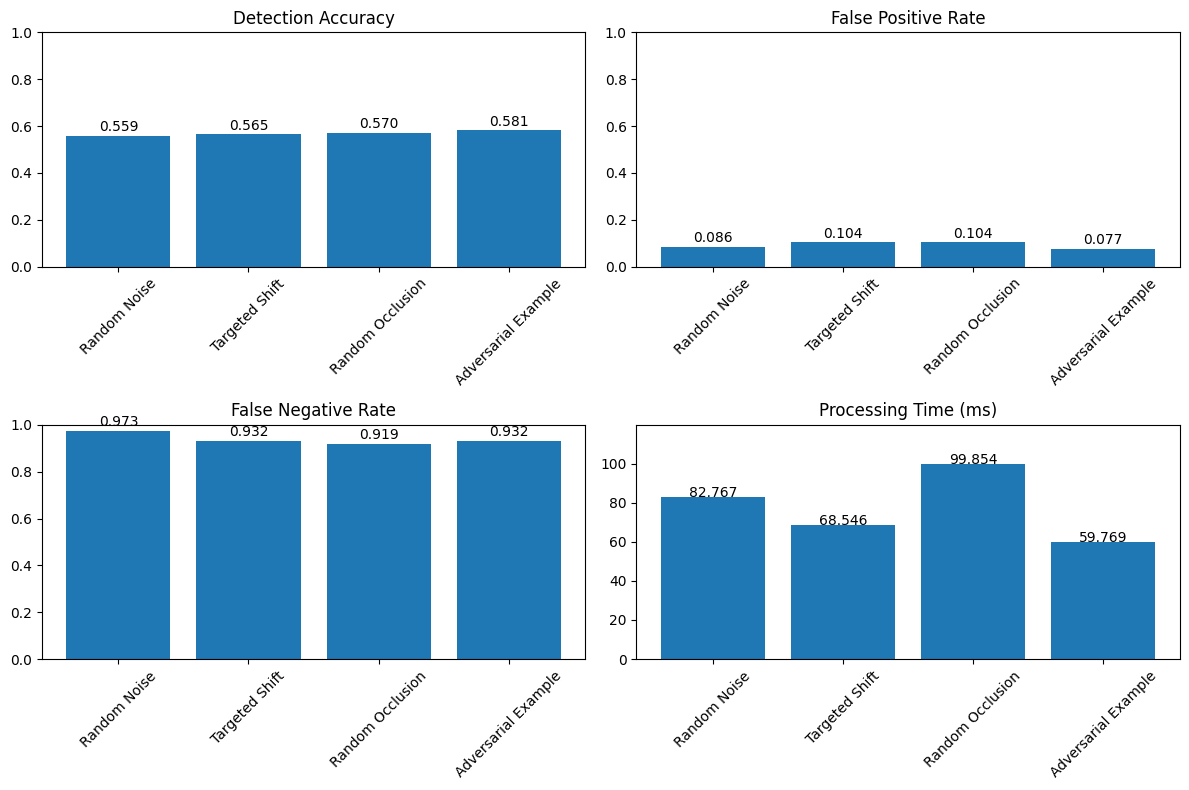

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import os
from torchvision import transforms

# Add any additional imports needed from your modules
# from models.feature_compression import FeatureCompressionVAE
# from models.diffusion import DiffusionModel
# from models.adversarial_defense import AdversarialDefenseSystem
# from data.dataset import VehicularPerceptionDataset


def apply_random_occlusion(images, occlusion_size=0.3):
    """Apply random occlusion to images"""
    perturbed = images.clone()
    batch_size, c, h, w = images.shape

    # Calculate occlusion dimensions
    occlude_height = int(h * occlusion_size)
    occlude_width = int(w * occlusion_size)

    # Apply occlusion to each image
    for i in range(batch_size):
        # Random position
        x = torch.randint(0, w - occlude_width, (1,)).item()
        y = torch.randint(0, h - occlude_height, (1,)).item()

        # Apply occlusion
        perturbed[i, :, y:y+occlude_height, x:x+occlude_width] = 0

    return perturbed


def generate_fgsm_attack(images, model, epsilon=0.1):
    """Generate adversarial examples using FGSM"""
    # Create a copy that requires gradient
    perturbed_images = images.clone().detach().requires_grad_(True)

    # Forward pass
    outputs, mu, log_var, _ = model(perturbed_images)

    # Calculate loss
    loss = F.mse_loss(outputs, images)

    # Backward pass
    loss.backward()

    # Generate perturbation
    perturbation = epsilon * perturbed_images.grad.sign()

    # Add perturbation
    perturbed_images = perturbed_images + perturbation

    # Ensure valid range
    perturbed_images = torch.clamp(perturbed_images, -1, 1)

    return perturbed_images.detach()


def visualize_results(results, config):
    """Visualize evaluation results"""
    # Create figure
    plt.figure(figsize=(12, 8))

    # Metrics to plot
    metrics = ['accuracy', 'false_positive', 'false_negative', 'latency']
    titles = ['Detection Accuracy', 'False Positive Rate', 'False Negative Rate', 'Processing Time (ms)']

    # Get attack names
    attack_names = list(results.keys())

    # Plot each metric
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plt.subplot(2, 2, i + 1)

        # Get values
        values = [results[attack][metric] for attack in attack_names]

        # Create bar plot
        plt.bar(attack_names, values)
        plt.title(title)
        plt.ylim(0, 1.0 if metric != 'latency' else max(values) * 1.2)
        plt.xticks(rotation=45)

        # Add value labels
        for j, v in enumerate(values):
            plt.text(j, v + 0.02, f"{v:.3f}", ha='center')

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(config.output_dir, 'evaluation_results.png')
    plt.savefig(save_path)
    print(f"Results visualization saved to {save_path}")
    plt.show()


def evaluate_defense_system(config):
    """
    Evaluate the adversarial defense system
    """
    # Create dataset
    dataset = VehicularPerceptionDataset(
        root_dir=config.data_dir,
        transform=None,  # No augmentation for evaluation
        is_training=False,
        num_vehicles=config.num_vehicles,
        adversarial_prob=0.0  # We'll add adversarial samples manually
    )

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    # Create models
    vae = FeatureCompressionVAE(
        input_channels=config.input_channels,
        latent_dim=config.latent_dim
    ).to(config.device)

    diffusion = DiffusionModel(
        feature_dim=config.latent_dim,
        timesteps=config.diffusion_timesteps
    ).to(config.device)

    # Load model weights
    checkpoint = torch.load(config.model_path, map_location=config.device)
    vae.load_state_dict(checkpoint['vae_state_dict'])
    diffusion.load_state_dict(checkpoint['diffusion_state_dict'])

    # Set models to evaluation mode
    vae.eval()
    diffusion.eval()

    # Create defense system
    defense_system = AdversarialDefenseSystem(
        vae=vae,
        diffusion=diffusion,
        latent_dim=config.latent_dim,
        num_vehicles=config.num_vehicles
    ).to(config.device)

    # Metrics
    detection_accuracy = 0.0
    false_positive_rate = 0.0
    false_negative_rate = 0.0
    processing_times = []

    # Run evaluation for different attack types
    attack_types = {
        'Random Noise': lambda x: x + torch.randn_like(x) * config.attack_magnitude,
        'Targeted Shift': lambda x: x + config.attack_magnitude,
        'Random Occlusion': lambda x: apply_random_occlusion(x),
        'Adversarial Example': lambda x: generate_fgsm_attack(x, vae)
    }

    # Results for each attack type
    results = {attack: {
        'accuracy': 0.0,
        'false_positive': 0.0,
        'false_negative': 0.0,
        'latency': 0.0
    } for attack in attack_types}

    # For each attack type
    for attack_name, attack_function in attack_types.items():
        print(f"\nEvaluating attack: {attack_name}")

        # Reset metrics
        correct_detections = 0
        false_positives = 0
        false_negatives = 0
        total_samples = 0
        total_benign = 0
        total_adversarial = 0

        # Process time
        total_time = 0.0

        # Process all batches
        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Evaluating {attack_name}")):
            # Get vehicle images
            if 'vehicle_images' in batch:
                vehicle_images = batch['vehicle_images']
                batch_size = vehicle_images[0].shape[0]

                # Create list for adversarial images - FIX: Initialize empty list first
                adversarial_images = []

                # Keep track of which vehicles are adversarial
                is_adversarial = np.zeros((batch_size, config.num_vehicles), dtype=bool)

                # Apply attack to selected vehicles
                for v in range(config.num_vehicles):
                    if v in config.adversarial_vehicles:
                        # Apply attack - move to device first
                        original_img = vehicle_images[v].to(config.device)
                        perturbed = attack_function(original_img)
                        adversarial_images.append(perturbed)

                        # Mark as adversarial
                        is_adversarial[:, v] = True
                    else:
                        # Keep original - move to device
                        adversarial_images.append(vehicle_images[v].to(config.device))

                # Measure processing time
                start_time = time.time()

                # Run detection
                detected_adversarial = defense_system.detect_adversarial(
                    adversarial_images,
                    threshold=config.adversarial_threshold
                )

                # Measure time
                end_time = time.time()
                processing_time = (end_time - start_time) * 1000  # ms

                # Update metrics
                for b in range(batch_size):
                    for v in range(config.num_vehicles):
                        # True adversarial status
                        true_adversarial = is_adversarial[b, v]

                        # Predicted adversarial status
                        pred_adversarial = detected_adversarial[b, v]

                        # Update counters
                        total_samples += 1

                        if true_adversarial:
                            total_adversarial += 1
                            if pred_adversarial:
                                correct_detections += 1
                            else:
                                false_negatives += 1
                        else:
                            total_benign += 1
                            if pred_adversarial:
                                false_positives += 1
                            else:
                                correct_detections += 1

                # Update total time
                total_time += processing_time

            # Limit evaluation to a few batches for quick testing
            if config.quick_eval and batch_idx >= 10:
                break

        # Calculate metrics
        accuracy = correct_detections / total_samples if total_samples > 0 else 0
        fp_rate = false_positives / total_benign if total_benign > 0 else 0
        fn_rate = false_negatives / total_adversarial if total_adversarial > 0 else 0
        avg_time = total_time / (batch_idx + 1)

        # Store results
        results[attack_name]['accuracy'] = accuracy
        results[attack_name]['false_positive'] = fp_rate
        results[attack_name]['false_negative'] = fn_rate
        results[attack_name]['latency'] = avg_time

        print(f"Results for {attack_name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  False Positive Rate: {fp_rate:.4f}")
        print(f"  False Negative Rate: {fn_rate:.4f}")
        print(f"  Average Processing Time: {avg_time:.2f} ms")

    # Visualize results
    visualize_results(results, config)

    return results


def evaluate_system(vae, diffusion, test_dir='/content/drive/MyDrive/CVProject/test/'):
    """
    Evaluate the trained system on test data
    """
    # Create configuration
    class EvalConfig:
        data_dir = test_dir
        batch_size = 4
        num_workers = 2
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        num_vehicles = 5
        adversarial_vehicles = [1, 3]  # Which vehicles to make adversarial
        adversarial_magnitude = 0.2
        output_dir = '/content/drive/MyDrive/CVProject/output/evaluation/'

    config = EvalConfig()
    os.makedirs(config.output_dir, exist_ok=True)

    # Create evaluation dataset
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    test_dataset = VehicularPerceptionDataset(
        root_dir=config.data_dir,
        transform=transform,
        is_training=False,
        num_vehicles=config.num_vehicles,
        adversarial_prob=0.0  # No random adversarial - we'll do it manually
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    # Create the full defense system
    # from models.adversarial_defense import AdversarialDefenseSystem, ThreatDetector

    # Move models to device
    vae = vae.to(config.device)
    diffusion = diffusion.to(config.device)

    # Create the defense system
    defense_system = AdversarialDefenseSystem(
        vae=vae,
        diffusion=diffusion,
        latent_dim=vae.fc_mu.out_features,  # Get latent dim from VAE
        num_vehicles=config.num_vehicles
    ).to(config.device)

    # Set models to evaluation mode
    vae.eval()
    diffusion.eval()
    defense_system.eval()

    # Metrics
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    # Process test data
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
        if 'vehicle_images' in batch:
            # Get vehicle images
            vehicle_images = batch['vehicle_images']
            batch_size = vehicle_images[0].shape[0]

            # Apply adversarial perturbations to selected vehicles
            for v_idx in config.adversarial_vehicles:
                if v_idx < len(vehicle_images):
                    # Apply adversarial perturbation
                    vehicle_images[v_idx] = defense_system._apply_adversarial_perturbation(
                        vehicle_images[v_idx],
                        magnitude=config.adversarial_magnitude
                    )

            # Move to device
            vehicle_images = [img.to(config.device) for img in vehicle_images]

            # Detect adversarial vehicles
            with torch.no_grad():
                results = defense_system.forward(vehicle_images, inference_mode=True)
                threat_results = results['threat_results']
                trust_scores = threat_results['trust_scores']

                # Threshold for adversarial detection
                is_adversarial = (trust_scores < 0.5).cpu().numpy()

            # Calculate metrics
            for v_idx in range(config.num_vehicles):
                ground_truth = v_idx in config.adversarial_vehicles

                for b in range(batch_size):
                    predicted = is_adversarial[b, v_idx]

                    if ground_truth and predicted:
                        true_positives += 1
                    elif ground_truth and not predicted:
                        false_negatives += 1
                    elif not ground_truth and predicted:
                        false_positives += 1
                    else:  # not ground_truth and not predicted
                        true_negatives += 1

            # Visualize results for the first batch
            if batch_idx == 0:
                fig, axes = plt.subplots(config.num_vehicles, 4, figsize=(16, 4*config.num_vehicles))

                for v_idx in range(config.num_vehicles):
                    for b in range(min(4, batch_size)):
                        # Get the image
                        img = vehicle_images[v_idx][b].cpu()

                        # Convert from [-1,1] to [0,1] for display
                        img = (img + 1) / 2

                        # Plot the image
                        ax = axes[v_idx, b]
                        ax.imshow(img.permute(1, 2, 0))

                        # Add title with adversarial status
                        is_adv = v_idx in config.adversarial_vehicles
                        predicted_adv = is_adversarial[b, v_idx]

                        title = f"V{v_idx}: "
                        title += "Adv" if is_adv else "Clean"
                        title += " (Detected)" if predicted_adv else " (Not Detected)"

                        # Color based on correct/incorrect prediction
                        if (is_adv and predicted_adv) or (not is_adv and not predicted_adv):
                            # Correct prediction
                            ax.set_title(title, color='green')
                        else:
                            # Incorrect prediction
                            ax.set_title(title, color='red')

                        ax.axis('off')

                plt.tight_layout()
                plt.savefig(os.path.join(config.output_dir, 'detection_results.png'))
                plt.show()

        # Limit to 10 batches for quick evaluation
        if batch_idx >= 10:
            break

    # Calculate metrics
    total = true_positives + true_negatives + false_positives + false_negatives
    accuracy = (true_positives + true_negatives) / total if total > 0 else 0

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Create confusion matrix
    confusion_matrix = [
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ]

    print("\nConfusion Matrix:")
    print(f"TN: {true_negatives}, FP: {false_positives}")
    print(f"FN: {false_negatives}, TP: {true_positives}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': confusion_matrix
    }


if __name__ == "__main__":
    # Configuration
    class Config:
        # Paths
        data_dir = '/content/drive/MyDrive/CVProject/'
        output_dir = '/content/drive/MyDrive/CVProject/output/'
        model_path = '/content/drive/MyDrive/CVProject/output/final_model.pt'

        # Model parameters
        input_channels = 3
        latent_dim = 64
        num_vehicles = 5
        diffusion_timesteps = 100

        # Evaluation parameters
        batch_size = 8
        num_workers = 2
        adversarial_vehicles = [1, 3]  # Indices of vehicles to attack
        adversarial_threshold = 0.5  # Trust score threshold
        attack_magnitude = 0.2  # Magnitude of adversarial perturbation

        # Quick evaluation flag (for testing)
        quick_eval = True

        # Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create output directory if it doesn't exist
    os.makedirs(Config.output_dir, exist_ok=True)

    # You need to add your module imports here, before running evaluation
    # from models.feature_compression import FeatureCompressionVAE
    # from models.diffusion import DiffusionModel
    # from models.adversarial_defense import AdversarialDefenseSystem, ThreatDetector
    # from data.dataset import VehicularPerceptionDataset

    # Run evaluation
    results = evaluate_defense_system(Config)